# The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import pickle
from moviepy.editor import VideoFileClip
import collections
%matplotlib inline

/Users/feleir/miniconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/feleir/miniconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Load training/test images

In [2]:
non_vehicle_images = glob.glob('./non-vehicles/**/*.png')
print('Found {} non-vehicle images.'.format(len(non_vehicle_images)))

vehicle_images = glob.glob('./vehicles/**/*.png')
print('Found {} vehicle images.'.format(len(vehicle_images)))


Found 8968 non-vehicle images.
Found 8792 vehicle images.


## Helper functions 

Helper functions for feature extration processing.

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  #block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       #block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        image_features = single_img_features(image, color_space, spatial_size, 
                                             hist_bins, orient,
                                             pix_per_cell, cell_per_block, hog_channel,
                                             spatial_feat, hist_feat, hog_feat)
        features.append(image_features)
        
    # Return list of feature vectors
    return features


## Extract features for vehicles and non vehicles features

Feature extraction parameters.

In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 128    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 700] # Min and max in y to search in slide_window()

In [5]:
vehicle_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
non_vehicle_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

Visualize features features

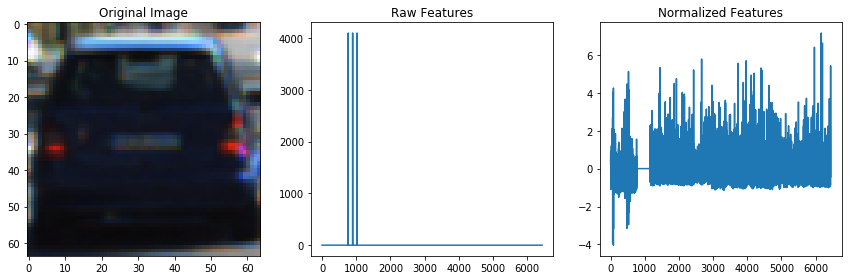

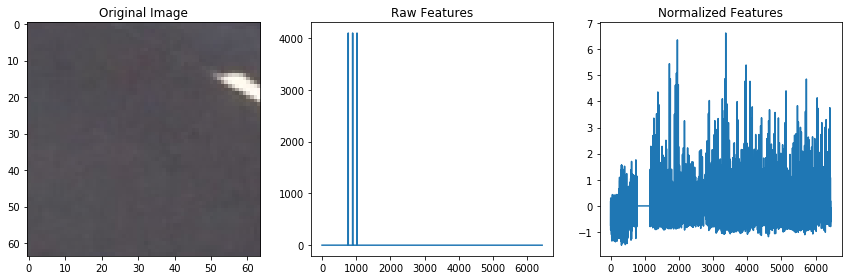

In [6]:
def show_random_features(images):
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    index = np.random.randint(0, len(images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(images[index]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[index])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[index])
    plt.title('Normalized Features')
    fig.tight_layout()

show_random_features(vehicle_images)
show_random_features(non_vehicle_images)

Visualize HOG features

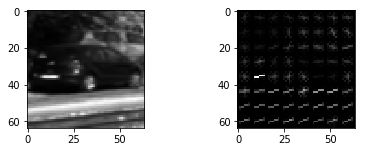

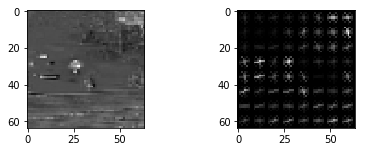

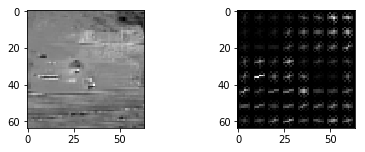

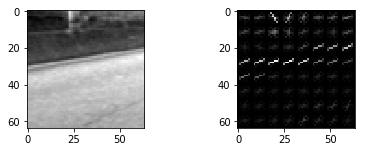

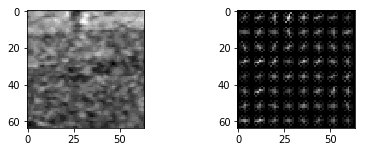

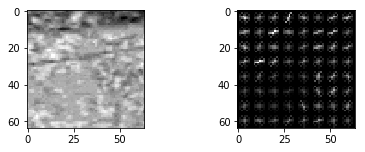

In [7]:
def show_image_with_hog(image, hog_image): 
    # Plot an example of raw and scaled features
    fig = plt.figure()
    plt.subplot(221)
    plt.imshow(image,cmap='gray')
    plt.subplot(222)
    plt.imshow(hog_image,cmap='gray')
    fig.tight_layout()
    
def show_hog_features(images): 
    index = np.random.randint(0, len(images))
    image = mpimg.imread(images[index])
    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    features_ch0, hog_image_ch0 = get_hog_features(feature_image[:,:,0],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    features_ch1, hog_image_ch1 = get_hog_features(feature_image[:,:,1],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    features_ch2, hog_image_ch2 = get_hog_features(feature_image[:,:,2],orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

    show_image_with_hog(feature_image[:,:,0], hog_image_ch0)
    show_image_with_hog(feature_image[:,:,1], hog_image_ch1)
    show_image_with_hog(feature_image[:,:,2], hog_image_ch2)

show_hog_features(vehicle_images)
show_hog_features(non_vehicle_images)

## Classifier training

In [8]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6444
23.14 Seconds to train SVC...
Test Accuracy of SVC =  0.9856


In [9]:
print('SVC params', svc.get_params())

SVC params {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [10]:
#Cs = np.logspace(-6, -1, 10)
#tol_list=[0.0001,0.00001]
#clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs,tol=tol_list))
#clf.fit(X_train, y_train)
#print('best score', clf.best_score_)
#print('best stimator', clf.best_estimator_)

# Vehicle detection

Load test images.

Found 6 test images


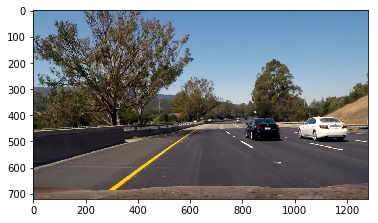

In [11]:
test_images = glob.glob('./test_images/*.jpg')
print('Found {} test images'.format(len(test_images)))

sample_test_image = mpimg.imread(test_images[0])
fig = plt.figure()
plt.imshow(sample_test_image)
plt.show()

Utility functions to find sliding windows and draw boxes.

In [12]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

Test sliding window creation with the test image.

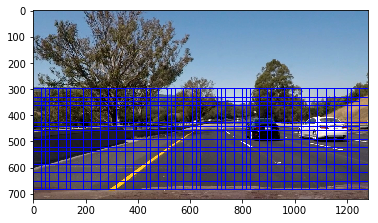

In [13]:
window_sizes = [(320, 320), (256, 256), (128, 128), (96, 96), (64, 64)]
test_windows = []
for window_size in window_sizes:
    step_windows = slide_window(sample_test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=window_size, xy_overlap=(0.5, 0.5))
    test_windows = test_windows + step_windows

copy_test_image = np.copy(sample_test_image)
test_windows_image = draw_boxes(copy_test_image, test_windows, color=(0, 0, 255), thick=2)
fig = plt.figure()
plt.imshow(test_windows_image)
plt.show()

Function to find the search windows for an image.

In [14]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    scaled_image = img.astype(np.float32) / 255
        
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        window_features = []
        #3) Extract the test window from original image
        test_img = cv2.resize(scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

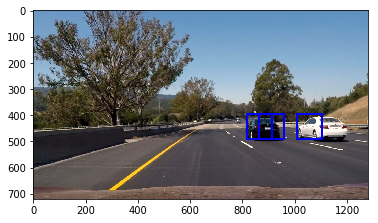

In [15]:
copy_test_image = np.copy(sample_test_image)
windows = slide_window(sample_test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(sample_test_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(copy_test_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

# Hog subsampling

Instead of getting hog_feature for every subimage the sub-sampling techinique allows to only extract hog features at once.

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Append window position to list
                window_list.append(((xbox_left,  ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                
    return window_list

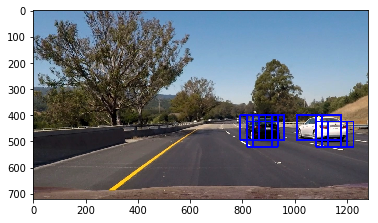

In [17]:
ystart = 400
ystop = 656
scale = 1.5
    
test_hog_subsampling_windows = find_cars(sample_test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

test_hog_subsampling_boxes_image = draw_boxes(sample_test_image, test_hog_subsampling_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(test_hog_subsampling_boxes_image)

The result with sub-sampling technique is much better and performant that using sliding-windows and performing hog feature calculation for every window we will like to test.

# Detect false positives and bound boxes

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Check the heat map for the test image.

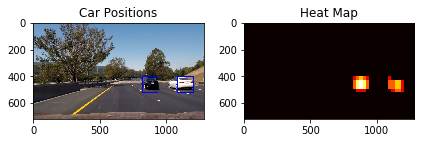

In [19]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(sample_test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,test_hog_subsampling_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(sample_test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Define image processing pipeline

In [20]:
def find_labeled_boxes(labels):
    bbox_list = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    return bbox_list

def process_bboxes(image, hot_windows, threshold,show_heatmap=False):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)  
    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bbox_list = find_labeled_boxes(labels)
    if show_heatmap:
        return bbox_list,heatmap
    else:
        return bbox_list
  
def draw_car_boxes(img, bbox_list):
    for bbox in bbox_list:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def process_image(img):
    # find sliding windows where cars are detected
    hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list = process_bboxes(img, hot_windows, 1)
    draw_img = draw_car_boxes(np.copy(img), bbox_list)
    
    return draw_img

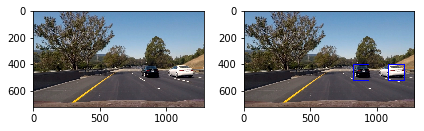

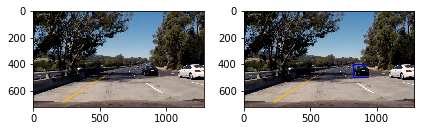

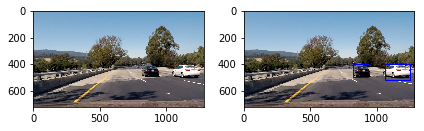

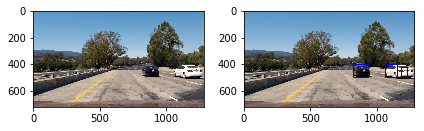

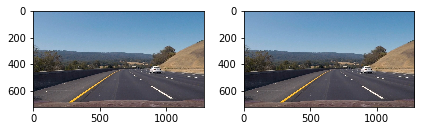

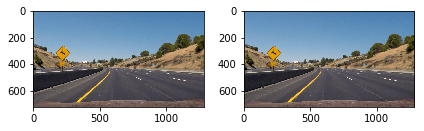

In [21]:
for img_file in test_images:
    img = mpimg.imread(img_file)
    draw_img = process_image(img)
    fig = plt.figure()
    plt.subplot(221)
    plt.imshow(img)
    plt.subplot(222)
    plt.imshow(draw_img)
    fig.tight_layout()

In [23]:
def add_heatmap_to_image(input_image, output_image, heatmap):
    #Merge heatmap with image
    sizeX = int(256*1.3)
    sizeY = int(144*1.3)
    heat2 = cv2.resize(heatmap, (sizeX,sizeY))
    res_img = cv2.resize(input_image, (sizeX,sizeY))
    res_img_gray = cv2.cvtColor(res_img , cv2.COLOR_RGB2GRAY)
    
    heat3=(heat2/np.max(heat2)*255).astype(int)   
    
    res_img_gray_R=res_img_gray
    res_img_gray_R[(heat2>0)] =255
    res_img_gray_G =res_img_gray
    res_img_gray_G[(heat2>0)] =0
    res_img_gray_B =res_img_gray
    res_img_gray_B[(heat2>0)] =0
    
    output_image[0:sizeY,0:sizeX,0]=res_img_gray_R + heat3
    output_image[0:sizeY,0:sizeX,1]=res_img_gray
    output_image[0:sizeY,0:sizeX,2]=res_img_gray   

previous_bboxes = collections.deque(maxlen=10)
def process_video_image(img, avg_threshold=7):
    hot_windows = []
    scales = [1, 1.5, 2, 2.5, 3]
    # Apply sliding windows technique for HOG features to compute
    for scale in scales:
        hot_windows = hot_windows + find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Identify boxes using threshold to avoid false positives
    bbox_list = process_bboxes(img,hot_windows,threshold=0,show_heatmap=False)
    
     # Add to previous bboxes
    previous_bboxes.append(bbox_list)
    # Get all hot boxes
    avg_bbox_list=[]
    for box in previous_bboxes:
        for b in box:
            avg_bbox_list.append(b)
    # Smoothing - Apply avg heatmap to further reduce false positives and smooth the bounding boxes
    bbox_list, heatmap = process_bboxes(img,avg_bbox_list,threshold=avg_threshold,show_heatmap=True)         
    draw_img = draw_car_boxes(img, bbox_list)
    add_heatmap_to_image(img, draw_img, heatmap)
    
    return draw_img
    
def process_video(input_video, output_video):
    previous_bboxes = collections.deque(maxlen=10)
    project_video = VideoFileClip(input_video)
    result_video = project_video.fl_image(process_video_image)
    result_video.write_videofile(output_video, audio=False)
    
process_video('project_video.mp4', 'project_video_output.mp4')

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [45:26<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [25]:
result_video = VideoFileClip('project_video_output.mp4').subclip(10, 12)
result_video.write_gif('video_output.gif')


[MoviePy] Building file video_output.gif with imageio


 98%|█████████▊| 50/51 [00:19<00:00,  2.52it/s]
